In [1]:
'''Prepare the notebook. Run this cell first.'''
import os, re, sys
import pandas as pd
import numpy as np
from IPython.display import Image

%load_ext rpy2.ipython

In [2]:
'''Set parameters.  Run this cell before all others.'''
study_name = 'merged_neighbor' #Change this to match your PLINK binary filestem (*.bed, *.bim, *.bam).
min_maf = 0.01 #Remove variants below this frequency. Set to 0 to keep all variants.
max_missing_sample_callrate = 0.03 #Remove samples that have greater than this percent of missing genotypes ("sample callrate").
max_missing_marker_callrate = 0.03 #Remove SNPs that have greater than this percent of missing calls ("marker callrate").
max_IBD = 0.125 #Remove samples that have identity by state greater than this coefficient of relationship (first cousins).
min_HWE_p = 0.00001 #Remove SNPs with HWE exact test p-values lower than this.
min_diffmiss_p = 0.00001 #Remove SNPs with differential missingness test p-values lower than this.

In [3]:
ncpu_string = !nproc #Linux command to return the number of CPUs.
ncpu = int(ncpu_string[0]) #Convert to Python integer.
ram_string = !cat /proc/meminfo | fgrep MemTotal | perl -lane 'use POSIX; print floor($F[1] / 1024) #Convert from kB to MB'
ram = int(ram_string[0])

In [4]:
'''Make analysis directory and upload your data'''

import os
study_dir = '/clink/' + study_name #Can change this variable to suit your study. 
#The base directory, /clink/, is the mountpoint for the encrypted EBS device.
if not os.path.isdir(study_dir): os.mkdir(study_dir)
%cd {study_dir}

#You can either upload data to the EC2 instance using the key pair you specified at instance launch,
#  for instance using scp from a system that has your data,
#  or you can fetch the data from this instance using SFTP/rsync/curl/wget/s3

#Remember that if you want to pull data from a private S3 bucket, the EC2 instance needs to assume an IAM role,
#  and that bucket must be configured for the EC2 instance's IAM role.

#In this example, I used scp from a firewalled and secured workstation to securely upload a Plink study to the EC2 instance.
#I used a command like this from my workstation:
#scp -i my_key_pair.pem my_study.* ec2-user@<IPv4_public_IP>:/gwas/my_study/
#  ..where <IPv4_public_IP> is the public IPv4 address of the EC2 instance running this notebook.

input_filestem  = study_name #This variable will be used throughout QC.

/clink/merged_neighbor


In [5]:
'''1) Run sex check using plink.'''

#This should generate a *.sexcheck file for the study:
!plink --bfile $input_filestem --check-sex --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --check-sex
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
528478 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5183 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%

In [6]:
sexcheck_file = input_filestem + '.sexcheck'
sexprobs_file = input_filestem + '.sexprobs'

!fgrep PROBLEM $sexcheck_file > $sexprobs_file
sexproblems = !cat $sexprobs_file | wc -l
print("Number of gender discordances detected: " + str(sexproblems))

#Save the FID and IID of the individuals that failed qc, if any.
#It's okay to generate an empty file here - we'll count the lines of each fail-* file later for a sumamry.
!perl -lne 's/^\s+//; @f = split; print join "\t", (@f[0..1])' $sexprobs_file >fail-sexcheck-qc.txt

#At this point, inspect the reasons for any gender discordances.  In this case, some genders are missing in the ped file:
!head -1 $sexcheck_file #For the header.
!head -5 $sexprobs_file #Check out the first 5 discordances.

Number of gender discordances detected: ['151']
         FID          IID       PEDSEX       SNPSEX       STATUS            F
      ME8001       ME8001            0            2      PROBLEM     -0.03751
      ME8002       ME8002            0            1      PROBLEM            1
      ME8003       ME8003            0            1      PROBLEM            1
      ME8004       ME8004            0            2      PROBLEM    -0.005969
      ME8005       ME8005            0            2      PROBLEM     -0.04629


In [7]:
'''Exclude samples that failed sexcheck QC.'''
!plink --bfile $input_filestem --remove fail-sexcheck-qc.txt --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --out merged_neighbor
  --remove fail-sexcheck-qc.txt

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528478 variants loaded from .bim file.
5183 people (2299 males, 2752 females, 132 ambiguous) loaded from .fam.
Ambiguous sex IDs written to merged_neighbor.nosex .
5051 phenotype values loaded from .fam.
--remove: 5032 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%

In [8]:
'''2) Marker callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.03
  --make-bed
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528478 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48

In [9]:
'''3) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --het
  --make-bed
  --mind 0.03
  --missing
  --out merged_neighbor

16049 MB RAM detected; reserving 8024 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528478 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%

Number of individuals who failed heterozygosity QC:['104']


In [28]:
'''4) MAF'''
!plink --bfile $input_filestem --maf $min_maf --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --maf 0.01
  --make-bed
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528395 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%

In [29]:
'''5) IBD'''
'''Generate LD-pruned variants first.'''
!plink --bfile $input_filestem --indep-pairwise 50 5 0.2 --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --indep-pairwise 50 5 0.2
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
528395 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%60%61%62%63%64%65%66%67%68%69%

In [30]:
'''If the above output pruned too few or too many SNPs, adjust the linkage R^2 value 
Increase R^2 to retain more SNPs, decrease to prune more.
The goal is to end up with about 100k SNPs for a GWAS study (>= 500k SNPs genome-wide).
Then proceed with identification of related samples.'''
prune_in_file = input_filestem + '.prune.in'
unlinked_variant_count = !cat $prune_in_file | wc -l
print "Unlinked (LD-pruned) genetic variant count: " + str(unlinked_variant_count)
!plink --bfile $input_filestem --extract $prune_in_file --genome --out $input_filestem
#That command should generate a *.genome file.  This might be the most computationally heavy cell in the notebook.
#IBD calculation "used to take weeks" according to a collaborator.  Plink's IBD computation is now fast.

Unlinked (LD-pruned) genetic variant count: ['112842']
PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --extract merged_neighbor.prune.in
  --genome
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
528395 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
--extract: 112842 variants remaining.
Using 1 thread.
Before main variant filters, 5032 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%

In [31]:
genome_file = input_filestem + '.genome'
#Clean up the whitespace:
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' $genome_file
genome_file_line_count = !wc -l $genome_file
print "Line count in genome file (used for relationship estimation): " + str(genome_file_line_count)
!head $genome_file

Line count in genome file (used for relationship estimation): ['12657997 merged_neighbor.genome']
FID1	IID1	FID2	IID2	RT	EZ	Z0	Z1	Z2	PI_HAT	PHE	DST	PPC	RATIO
NA1001	NA1001	NA1002	NA1002	UN	NA	0.9865	0.0000	0.0135	0.0135	NA	0.749563	0.5046	2.0008
NA1001	NA1001	NA1003	NA1003	UN	NA	0.9876	0.0000	0.0124	0.0124	NA	0.748920	0.7483	2.0462
NA1001	NA1001	NA1004	NA1004	UN	NA	0.9864	0.0000	0.0136	0.0136	NA	0.749015	0.8384	2.0688
NA1001	NA1001	NA1005	NA1005	UN	NA	0.9847	0.0000	0.0153	0.0153	NA	0.750048	0.3009	1.9649
NA1001	NA1001	NA1006	NA1006	UN	NA	0.9672	0.0261	0.0067	0.0197	NA	0.750384	0.5768	2.0133
NA1001	NA1001	NA1007	NA1007	UN	NA	0.9820	0.0055	0.0125	0.0153	NA	0.749904	0.6118	2.0195
NA1001	NA1001	NA1008	NA1008	UN	NA	0.9704	0.0264	0.0032	0.0164	NA	0.749538	0.8093	2.0609
NA1001	NA1001	NA1009	NA1009	UN	NA	0.9869	0.0000	0.0131	0.0131	NA	0.749327	0.2695	1.9586
NA1001	NA1001	NA1010	NA1010	UN	NA	0.9856	0.0000	0.0144	0.0144	NA	0.748985	0.1260	1.9240


In [32]:
'''Generate a file containing FID:IID pairs of individuals to be excluded on the basis of relatedness.
Exclude the individual with greater missingness from any pair of individuals that are related more than first cousins.'''
imiss, removed = dict(), set()

with open(imiss_file) as imiss_in, open(genome_file) as genome_in, open('fail-IBD-QC.txt', 'w') as fail_IBD_out:
    #Read the missingness into a dictionary.
    header = imiss_in.readline()
    for line in imiss_in:
        fid, iid, miss_pheno, n_miss, n_geno, f_miss = line.rstrip().split("\t") #File was already whitespace-cleaned.
        imiss[(fid, iid)] = float(f_miss) #Key by FID:IID tuple, value by F_MISS (missing frequency).
        
    #Now exclude related samples. Drop whichever one has higher missingness.
    header = genome_in.readline()
    for line in genome_in:
        fid1, iid1, fid2, iid2, rt, ez, z0, z1, z2, pi_hat, phe, dst, ppc, ratio = line.rstrip().split("\t")
        if float(pi_hat) > 0.185:
            if imiss[(fid1, iid1)] >= imiss[(fid2, iid2)]: #The first sample has higher missingness.
                if (fid1, iid1) not in removed:
                    fail_IBD_out.write("\t".join([fid1, iid1]) + "\n")
                    removed.add((fid1, iid1)) #Remember that we already excluded this FID:IID pair.
            else: #The second sample has higher missingness.
                if (fid2, iid2) not in removed:
                    fail_IBD_out.write("\t".join([fid2, iid2]) + "\n")
                    removed.add((fid2, iid2))

fail_IBD_count = !cat fail-IBD-QC.txt | wc -l
print "Number of samples that failed IBD QC: " + str(fail_IBD_count)

Number of samples that failed IBD QC: ['83']


In [33]:
'''Now exclude the related samples from the study.'''
!plink --bfile $input_filestem --remove fail-IBD-QC.txt --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --out merged_neighbor
  --remove fail-IBD-QC.txt

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528395 variants loaded from .bim file.
5032 people (2296 males, 2736 females) loaded from .fam.
5032 phenotype values loaded from .fam.
--remove: 4949 people remaining.
Using 1 thread.
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%

In [34]:
'''6) Outlying heterozygosity.
First, visualize missingness and heterozygosity from reports.'''

!plink --bfile $input_filestem --missing --het --out $input_filestem
imiss_file = input_filestem + '.imiss'
het_file   = input_filestem + '.het'

#!head {imiss_file} #See how Plink generates some extra whitespace...
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' {imiss_file} {het_file} 
#!head {imiss_file} #Uncomment to see how this Perl one-liner cleaned up these two files for easy reading.
#Now the whitespace is cleaned up, and the original het and imiss files are backed up as *.het.bak and *.imiss.bak

'Now that related samples have been excluded, repeat the marker callrate, sample callrate, and MAF filtering.'

In [ ]:
'''Plot missingness versus heterozygosity. Use Rmagic.'''

%Rpush imiss_file het_file
%R imiss <- read.table(imiss_file, header=T)
%R het   <- read.table(het_file,   header=T)
%R library(ggplot2)
%R library(cowplot)

#Calculate the log10 of the F_MISS and the mean heterozygosity (among non-missing genotypes).
%R imiss$logF_MISS <- log10(imiss$F_MISS)
%R het$meanHet     <-  (het$N.NM. - het$O.HOM.)/het$N.NM.

%R -o summary_logF_MISS summary_logF_MISS <- summary(imiss$logF_MISS)
print("Summary of log10(missingness): " + str(summary_logF_MISS))

%R -o summary_meanHet summary_meanHet <- summary(het$meanHet)
print("Summary of mean heterozygosity: " + str(summary_meanHet))

%R imiss_and_het <- merge(imiss, het, by='IID')


%R imiss_vs_het_scatterplot <- ggplot(imiss_and_het, aes(x=logF_MISS, y=meanHet)) + geom_point(alpha=0.3, colour='steelblue') + xlab("Proportion of Missing Genotypes (log10)") + ylab("Mean Autosomal Heterozygosity")
%R ggsave('imiss_vs_het.pdf') #Save publication-quality PDF.
%R ggsave('imiss_vs_het.png') #Save PNG for display in the notebook.
Image('imiss_vs_het.png')
#Inspect this plot for the distribution of missingness (x-axis) versus mean heterozygosity (y-axis).
#One can exclude samples with outlying heterozygosity, e.g. more than 3 standard deviations below the mean.

#Here's something similar in pure R:
#%R plot(imiss$logF_MISS, het$meanHet, pch=1, xlab="Proportion of missing genotypes", ylab="Heterozygosity rate",axes=F); axis(2,at=c(0,0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5),tick=T); axis(1,at=c(-3,-2,-1,0),labels=c(0.001,0.01,0.1,1)); abline(h=mean(het$meanHet) - (2 * sd(het$meanHet)), col="RED",  lty=2); abline(h=mean(het$meanHet) - (3 * sd(het$meanHet)), col="gray", lty=2); abline(h=mean(het$meanHet) + (2 * sd(het$meanHet)), col="red",  lty=2); abline(h=mean(het$meanHet) + (3 * sd(het$meanHet)), col="gray",  lty=2); abline(v=-1.522879, col="red", lty=2)


In [ ]:
'''Write file containing FID:IID pairs for individuals with outlying heterozygosity'''
%R het.filt <- het[which( het$meanHet > (mean(het$meanHet) + 3 * sd(het$meanHet)) | het$meanHet < (mean(het$meanHet) - 3 * sd(het$meanHet)) ),]
%R write.table(het.filt[,c(0,1)], file="fail-het-qc.txt", sep="\t", row.names=F, quote=F)

In [ ]:
fail_het_qc_count = !cat fail-het-qc.txt | wc -l
print("Number of individuals who failed heterozygosity QC:" + str(fail_het_qc_count))
!plink --bfile $input_filestem --remove fail-het-qc.txt --make-bed --out $input_filestem

In [ ]:
'''Now that we've excluded related samples and optionally samples with outlying autosomal heterozygosity,
we repeat the marker callrate, sample callrate, and MAF steps before finally proceeding to HWE/diffmiss/PCA.'''

In [36]:
'''7) Marker callrate.  This might not remove any SNPs, but it is important to retain guarantees about callrate.'''
!plink --bfile $input_filestem --geno $max_missing_marker_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --geno 0.03
  --make-bed
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528395 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%

In [39]:
'''8) Sample callrate.'''
!plink --bfile $input_filestem --mind $max_missing_sample_callrate --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --make-bed
  --mind 0.03
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528395 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
0 people removed due to missing genotype data (--mind).
Using 1 thread.
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%4

In [41]:
'''9) MAF'''
!plink --bfile $input_filestem --maf $min_maf --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --maf 0.01
  --make-bed
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
528395 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%

In [54]:
'''10) HWE. If you wish to base this test only on cases,
which requires your PED file to have accurate case/control phenotype encodings,
you can omit the --include-nonctrl option.
The mid-p modifier is recommended by Plink.'''

!plink --bfile $input_filestem --hwe $min_HWE_p midp include-nonctrl --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --hwe 1e-05 midp include-nonctrl
  --make-bed
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
519191 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Using 1 thread.
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%

In [56]:
'''11) Differential missingness (differential sample callrate).
This step relies on accurate case/control phenotype encodings in the FAM file.'''
!plink --bfile $input_filestem --test-missing --out $input_filestem
diffmiss_file = input_filestem + '.missing'
!perl -i.bak -lpe 's/^\s+//; s/\s+/\t/g;' {diffmiss_file} #Clean up whitespace.
diffmiss_snp_count = 0
with open('fail-diffmis-qc.txt', 'w') as fail_diffmiss, open(diffmiss_file) as diffmiss:
    header = diffmiss.readline() #Skip header line.
    for line in diffmiss:
        CHROM, SNP, F_MISS_A, F_MISS_U, P = line.rstrip().split("\t")
        if P < min_diffmis_p:
            diffmiss_snp_count += 1
            fail_difmiss.write(SNP + "\n")

print "SNPs that failed differential missingness:", diffmiss_snp_count

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --out merged_neighbor
  --test-missing

995 MB RAM detected; reserving 497 MB for main workspace.
519191 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Error: --test-missing requires a case/control phenotype.
Can't open merged_neighbor.missing: No such file or directory.


IOError: [Errno 2] No such file or directory: 'merged_neighbor.missing'

In [57]:
'''Exclude variants that failed differential missingness (if any).'''
!plink --bfile $input_filestem --exclude diffmiss_file --make-bed --out $input_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor.log.
Options in effect:
  --bfile merged_neighbor
  --exclude diffmiss_file
  --make-bed
  --out merged_neighbor

995 MB RAM detected; reserving 497 MB for main workspace.
Note: --make-bed input and output filenames match.  Appending '~' to input
filenames.
519191 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
Error: Failed to open diffmiss_file.


In [23]:
'''12) PCA'''
#First, try to merge the study's genotypes with the 1000 Genomes Project, phase 3, version 5a.
#We'll try a 5 step approach: merge, flip, merge, exclude, merge.
merged_filestem = 'merged' #We can do this in 5 steps with 3 filestems.  This is the output filestem.
flipped_filestem = 'flipped' #This filestem holds flipped 1kGP variants that failed the first merge.
flipmerged_filestem = 'flipmerged' #This filestem holds the results of the merge with the flipped 1kGP.
thousand_genomes_filestem = '/clink/1kGP/1kGP_no_ATCG_LD_pruned' #This dataset contains 36.5M LD-pruned 1kGP variants.

In [24]:
'''First, we'll intersect the rsIDs between the two datasets to thin down the size of the merged dataset.
Plink's --bmerge currently generates the union, which in this case will result in at least the 36.5M variants
from the 1000 Genomes Project.  Intersecting by ID might miss some rsID changes with identical chrom-pos-ref-alt.'''
snps_in_study, snps_in_1kGP = set(), set() #Populate these with IDs, then intersect them.
with open(input_filestem + '.bim') as study_bim, open(thousand_genomes_filestem + '.bim') as thousand_genomes_bim:
    for line in study_bim:
        fields = line.rstrip().split("\t")
        snps_in_study.add(fields[1]) #The second column of the BIM file holds the rsID.
    for line in thousand_genomes_bim:
        fields = line.rstrip().split("\t")
        snps_in_1kGP.add(fields[1])
        
print "SNPs in study (post-QC):", len(snps_in_study)
print "SNPs in 1000 Genomes Project:", len(snps_in_1kGP)
intersection_snps = snps_in_study.intersection(snps_in_1kGP) #Python set.
print "Intersection:", len(intersection_snps)
with open('intersection_snps.txt', 'w') as intersection_snps_file:
    for snp in intersection_snps:
        intersection_snps_file.write(snp + "\n")

SNPs in study (post-QC): 519191
SNPs in 1000 Genomes Project: 36561718
Intersection: 50212


In [27]:
'''Now generate a thinned down version of each study to merge, containing only intersecting SNPs.'''
intersection_input_filestem = input_filestem + '_intersection'
intersection_1kGP_filestem  = thousand_genomes_filestem + '_intersection'
!plink --bfile $input_filestem --extract intersection_snps.txt --make-bed --out $intersection_input_filestem
!plink --bfile $thousand_genomes_filestem --extract intersection_snps.txt --make-bed --out $intersection_1kGP_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged_neighbor_intersection.log.
Options in effect:
  --bfile merged_neighbor
  --extract intersection_snps.txt
  --make-bed
  --out merged_neighbor_intersection

16048 MB RAM detected; reserving 8024 MB for main workspace.
519191 variants loaded from .bim file.
4949 people (2276 males, 2673 females) loaded from .fam.
4949 phenotype values loaded from .fam.
--extract: 50212 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4949 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%

In [28]:
#1: Try an initial merge.
!plink --bfile $intersection_input_filestem --bmerge $intersection_1kGP_filestem --make-bed --out $merged_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to merged.log.
Options in effect:
  --bfile merged_neighbor_intersection
  --bmerge /clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection
  --make-bed
  --out merged

16048 MB RAM detected; reserving 8024 MB for main workspace.
4949 people loaded from merged_neighbor_intersection.fam.
2504 people to be merged from
/clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection.fam.
Of these, 2504 are new, while 0 are present in the base dataset.
50212 markers loaded from merged_neighbor_intersection.bim.
50212 markers to be merged from
/clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection.bim.
Of these, 0 are new, while 50212 are present in the base dataset.
Error: 24932 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  merged-merge.missnp.
  (Warning: if this seems to work, strand errors involv

In [29]:
'''Now, try to flip the SNPs that failed to merge.'''
missnp_file = merged_filestem + '-merge.missnp' #This holds the variants that failed to merge.
missnp_count = !wc -l $missnp_file
print "SNPs that failed to merge:", missnp_count
print "Flipping SNPs that failed to merge.\n"
!plink --bfile $intersection_1kGP_filestem --flip $missnp_file --make-bed --out $flipped_filestem

SNPs that failed to merge: ['24932 merged-merge.missnp']
Flipping SNPs that failed to merge.

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to flipped.log.
Options in effect:
  --bfile /clink/1kGP/1kGP_no_ATCG_LD_pruned_intersection
  --flip merged-merge.missnp
  --make-bed
  --out flipped

16048 MB RAM detected; reserving 8024 MB for main workspace.
50212 variants loaded from .bim file.
2504 people (0 males, 0 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to flipped.nosex .
--flip: 24932 SNPs flipped.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2504 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%

In [32]:
'''Now try to merge with the flipped SNPs.'''
!plink --bfile $intersection_input_filestem --bmerge $flipped_filestem --make-bed --out $flipmerged_filestem

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to flipmerged.log.
Options in effect:
  --bfile merged_neighbor_intersection
  --bmerge flipped
  --make-bed
  --out flipmerged

16048 MB RAM detected; reserving 8024 MB for main workspace.
4949 people loaded from merged_neighbor_intersection.fam.
2504 people to be merged from flipped.fam.
Of these, 2504 are new, while 0 are present in the base dataset.
50212 markers loaded from merged_neighbor_intersection.bim.
50212 markers to be merged from flipped.bim.
Of these, 0 are new, while 50212 are present in the base dataset.
Performing single-pass merge (7453 people, 50212 variants).
Merged fileset written to flipmerged-merge.bed + flipmerged-merge.bim +
flipmerged-merge.fam .
50212 variants loaded from .bim file.
7453 people (2276 males, 2673 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to flipmerged.n

In [14]:
'''If that above step didn't end in "Error: XXX variants with 3+ alleles present",
then you have a successful merge and can skip the next step (exclusion of flipped SNPs that failed to merge).'''
flipmerged_missnp_file = flipmerged_filestem + '-merge.missnp'
flipmerged_missnp_count = !wc -l flipmerged_missnps_file
print "SNPs that failed to merge after flipping:", flipmerged_missnp_count
print "Excluding flipped SNPs that failed to merge.\n"
!plink --bfile $flipped_filestem --exclude $flipmerged_missnp_file --make-bed --out $flipped_filestem

/clink/CLINK


In [ ]:
'''Now try to merge with the flipped SNPs after removal of those that failed to merge.'''
!plink --bfile $input_filestem --bmerge $flipped_filestem --make-bed --out $flipmerged_filestem

In [ ]:
'''Clean up intermediate files.'''

In [33]:
'''Now that the study is successfully merged with 1kGP, call PC1-20 and make plots.'''
!plink --bfile $flipmerged_filestem --pca header tabs var-wts

PLINK v1.90b3.45 64-bit (13 Jan 2017)      https://www.cog-genomics.org/plink2
(C) 2005-2017 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to plink.log.
Options in effect:
  --bfile flipmerged
  --pca header tabs var-wts

16048 MB RAM detected; reserving 8024 MB for main workspace.
50212 variants loaded from .bim file.
7453 people (2276 males, 2673 females, 2504 ambiguous) loaded from .fam.
Ambiguous sex IDs written to plink.nosex .
4949 phenotype values loaded from .fam.
Using up to 4 threads (change this with --threads).
Before main variant filters, 7453 founders and 0 nonfounders present.
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%53%54%55%56%57%58%59%

In [58]:
'''Now add a column that contains the population label from the 1000 Genomes project.'''
with open('plink.eigenvec') as eigenvec_in, open('/clink/1kGP/1kGP_populations.tsv') as populations_in, open('plink.eigenvec.labeled', 'w') as eigenvec_out:
    eigenvec_header = eigenvec_in.readline().rstrip() + "\tPopulation\tSuperpopulation\n" #Fix up header.
    eigenvec_out.write(eigenvec_header)
    populations = dict() #Key by sample ID (IID), value by population (26 different populations).
    populations_header = populations_in.readline() #"Sample Population\n"
    for line in populations_in:
        sample, population = line.rstrip().split("\t") #Tab delimited.
        populations[sample] = population #One of 26 populations.
    
    superpopulations = {'CHB': 'EAS', 'JPT': 'EAS', 'CHS': 'EAS', 'CDX': 'EAS', 'KHV': 'EAS',
                        'CEU': 'EUR', 'TSI': 'EUR', 'FIN': 'EUR', 'GBR': 'EUR', 'IBS': 'EUR',
                        'YRI': 'AFR', 'LWK': 'AFR', 'GWD': 'AFR', 'MSL': 'AFR', 'ESN': 'AFR', 'ASW': 'AFR', 'ACB': 'AFR',
                        'MXL': 'AMR', 'PUR': 'AMR', 'CLM': 'AMR', 'PEL': 'AMR',
                        'GIH': 'SAS', 'PJL': 'SAS', 'BEB': 'SAS', 'STU': 'SAS', 'ITU': 'SAS'}
    
    for line in eigenvec_in:
        fields = line.rstrip().split("\t") #FID, IID, PC1, PC2, ..., PC20
        IID = fields[1]
        if populations.has_key(fields[1]): #IID is in fields[1].
            population = populations.get(IID, study_name) #Assume all non-1kGP samples are in the study.
            superpopulation = superpopulations.get(population, "NA")
        else:
            population = study_name
            superpopulation = study_name
        eigenvec_out.write("\t".join(fields) + "\t" + population + "\t" + superpopulation + "\n")

7453 plink.eigenvec.labeled
HG00096	HG00096	-0.00571991	-0.00458004	-0.00183095	-0.00285559	0.00688944	0.00222582	0.000444802	0.00362207	-0.00321206	0.00709227	-0.00465345	-0.00940018	0.0160787	0.000890006	-0.011594	0.00898443	0.0189101	0.0173175	-0.000993511	-0.00739766	GBR	EUR
HG00097	HG00097	-0.00552595	-0.00463498	0.0006373	-0.00265886	0.00312281	-0.00248311	0.0110774	0.0085749	-0.0271378	0.0100326	0.00456731	-0.0044567	-0.00130036	-0.000495097	-0.00900265	0.0192496	0.00344021	0.00593823	0.00886295	-0.0128862	GBR	EUR
HG00099	HG00099	-0.00607327	-0.00481595	0.000526905	-0.00339279	0.00901741	-0.000713587	0.0159873	0.0125683	-0.0161937	0.0144253	-0.000438733	-0.00402205	0.00855706	0.016531	-0.0189848	-0.0122331	0.00728627	0.0208909	-0.00719048	0.00270708	GBR	EUR
HG00100	HG00100	-0.00562803	-0.00488635	0.000177582	-0.00340503	0.0074525	-0.00265056	0.00117274	0.00457181	0.00192479	0.0199941	0.000494052	-0.000233783	0.00937243	-0.023407	-0.0305866	0.00764364	0.000920845	-0.00312344	0.00

In [90]:
'''Now plot PC1 against PC2.'''
%R pca <- read.table("plink.eigenvec.labeled", sep="\t", header=T)
%R library(ggplot2)
%R library(cowplot, quietly=T)
%R pc1_vs_pc2_plot <- ggplot(pca, aes(x=PC1, y=PC2, colour=Superpopulation)) + geom_point(alpha=0.3)
%R ggsave('pc1_vs_pc2_plot.pdf')
%R ggsave('pc1_vs_pc2_plot.png') #For viewing in the notebook.

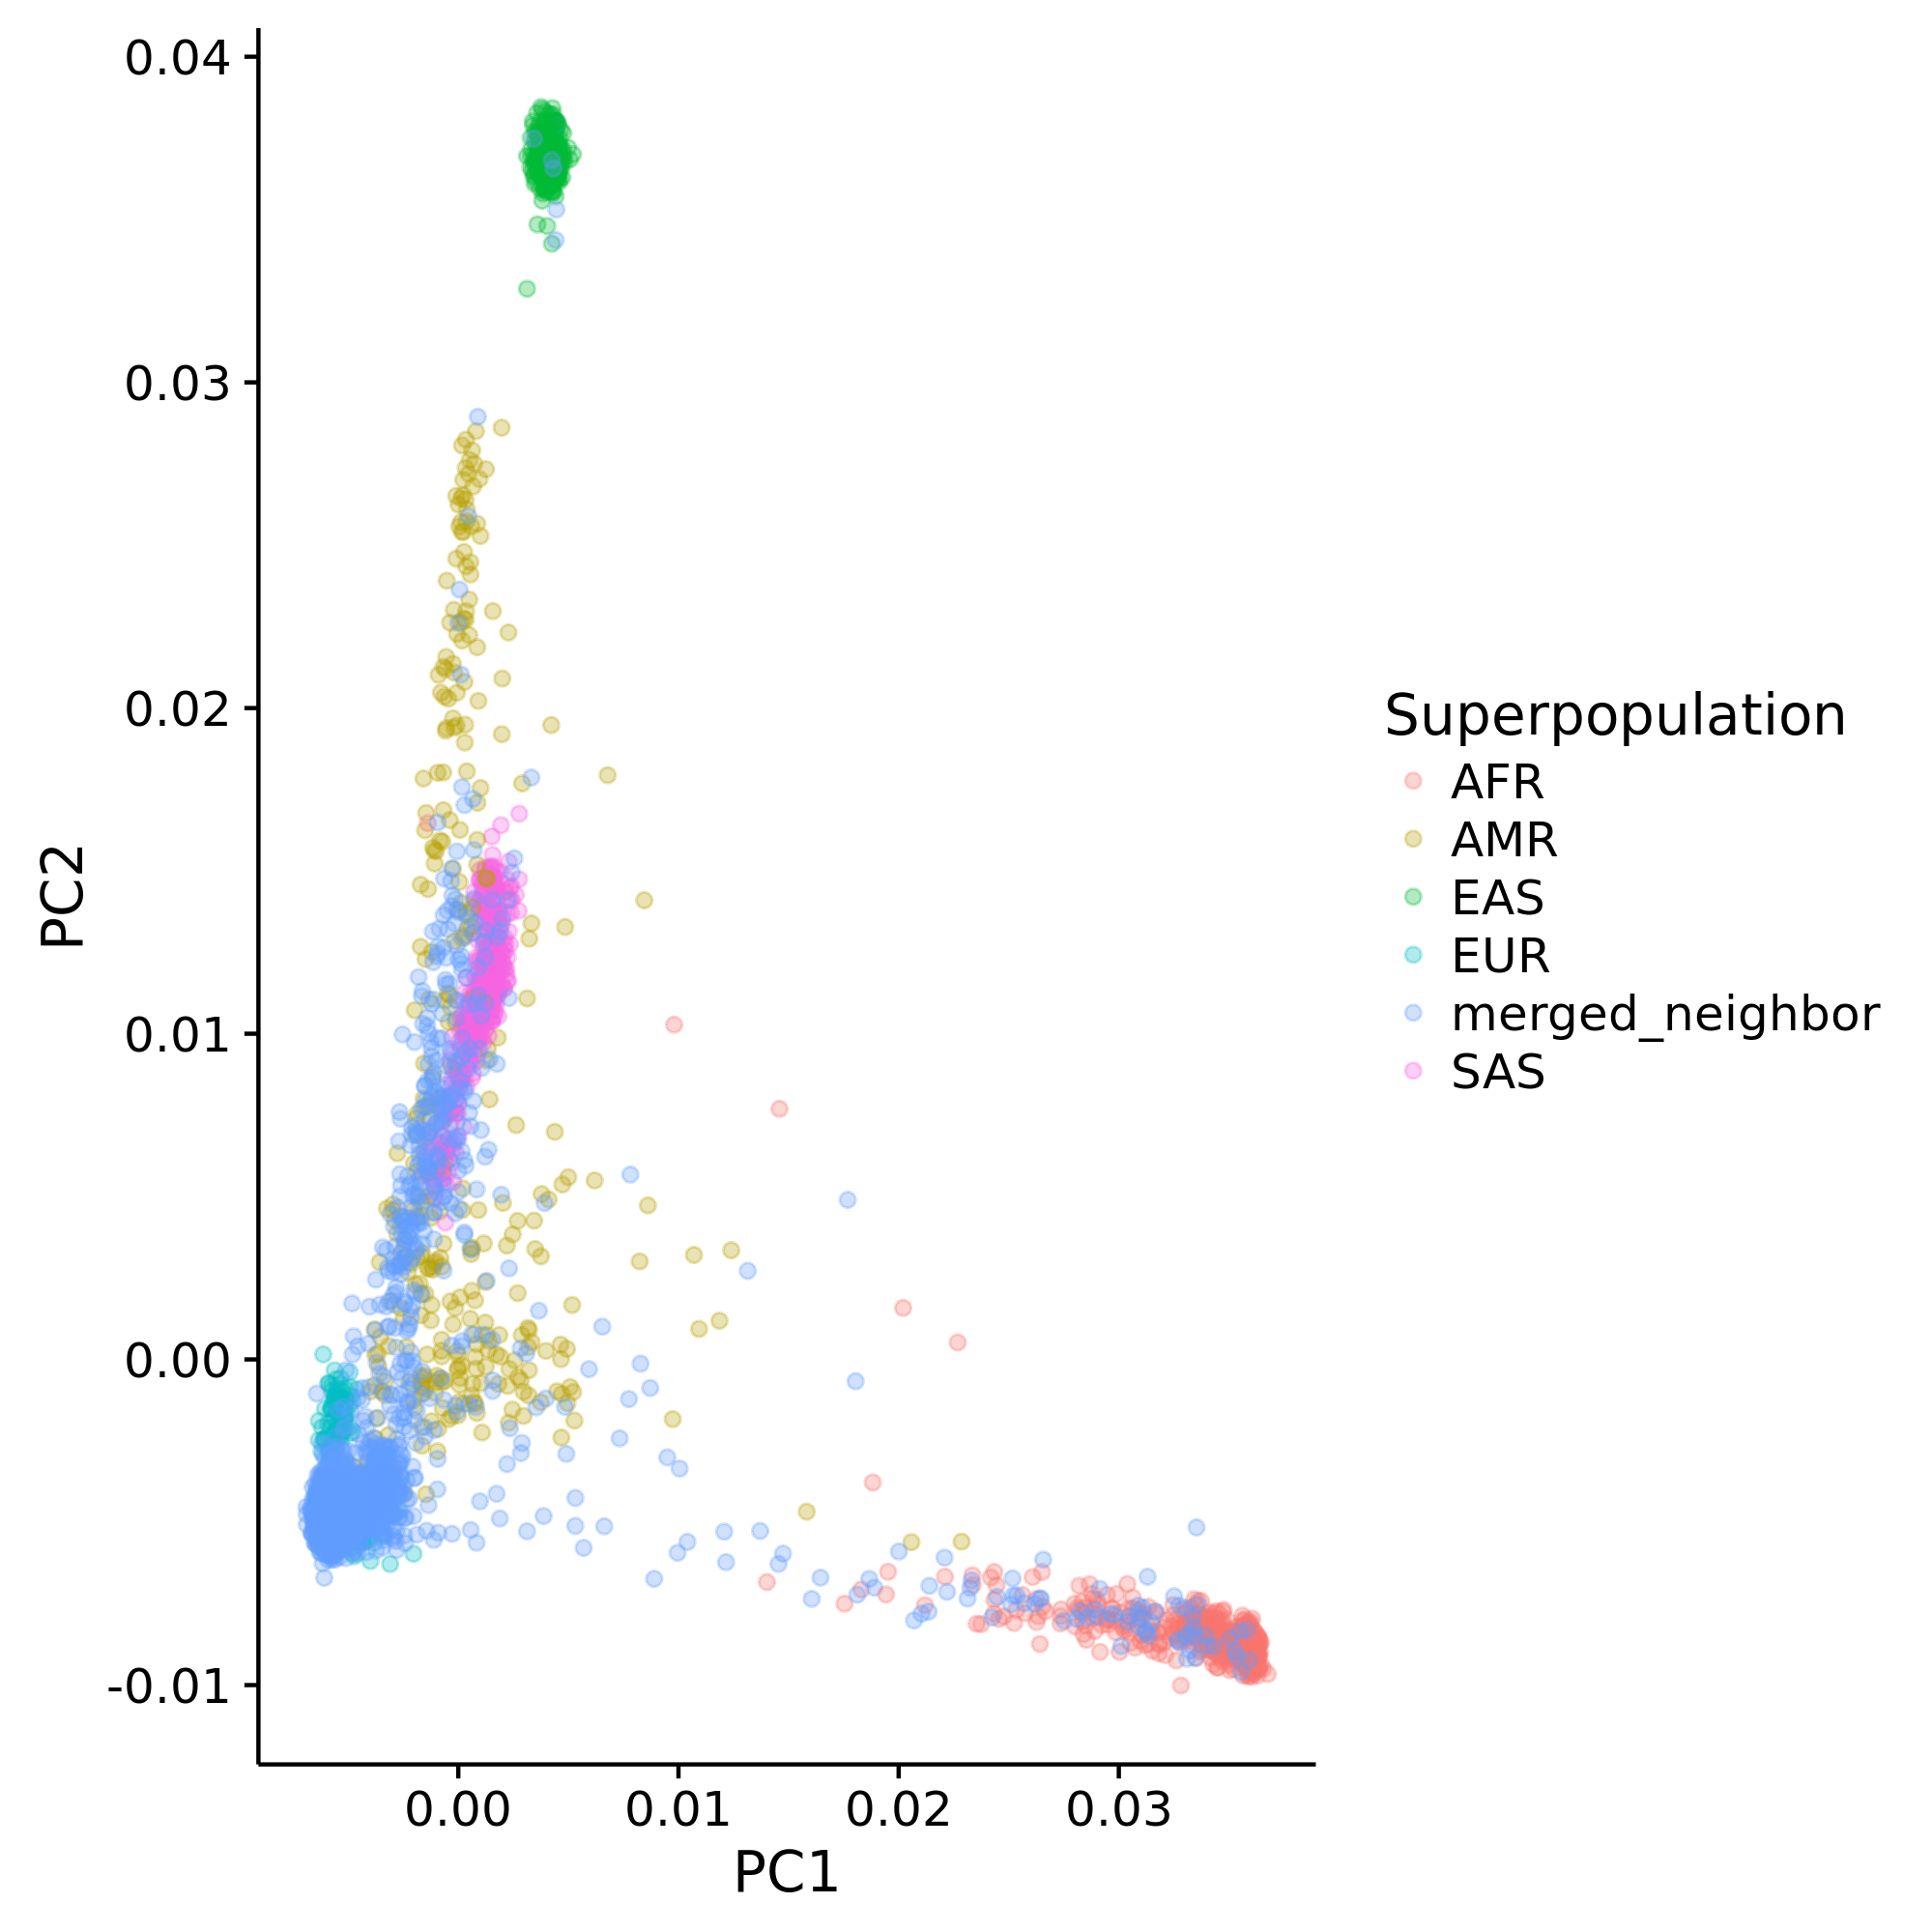

In [91]:
Image("pc1_vs_pc2_plot.png")